In [1]:
# Import necessary libraries
import glob
from pathlib import Path
import warnings

import lpips
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage.color import lab2rgb, rgb2lab
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm.notebook import tqdm

import torch
import torchvision.models as models
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from colormath.color_objects import LabColor, sRGBColor

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*negative Z values.*')

In [2]:
# Device configuration
def get_device():
    if torch.cuda.is_available():
        dev = torch.device("cuda")
        name = torch.cuda.get_device_name(0)
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        dev = torch.device("mps")
        name = "Apple Silicon"
    else:
        dev = torch.device("cpu")
        name = "CPU"
    return dev, name

device, device_name = get_device()
print(f"Using device: {device_name} ({device})")

Using device: NVIDIA GeForce RTX 5060 Ti (cuda)


In [3]:
# Configuration
MODEL_ID = 'A'
BATCH_SIZE = 64
IMG_SIZE = 256
EPOCHS = 50
SAVE_INTERVAL = 10

# Model-specific configuration
USE_GAN = False
USE_L1 = True
USE_PERCEPTUAL = False
LAMBDA_L1 = 100.0
LAMBDA_PERCEPTUAL = 0.0

print(f"Model {MODEL_ID} Configuration:")
print(f"  GAN: {USE_GAN}")
print(f"  L1 Loss: {USE_L1} (λ₁ = {LAMBDA_L1})")
print(f"  Perceptual Loss: {USE_PERCEPTUAL}")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")

Model A Configuration:
  GAN: False
  L1 Loss: True (λ₁ = 100.0)
  Perceptual Loss: False
  Epochs: 50
  Batch Size: 64


In [4]:
# Dataset class (copy from main experiment)
class ColorizeDataset(Dataset):
    def __init__(self, root_dir, img_size=256, split='train'):
        self.root_dir = Path(root_dir)
        self.img_size = img_size
        self.split = split
        
        color_dir = self.root_dir / f"{split}_color"
        self.color_paths = sorted(glob.glob(str(color_dir / "*.jpg")))
        
        black_dir = self.root_dir / f"{split}_black"
        self.black_paths = sorted(glob.glob(str(black_dir / "*.jpg")))
        
        assert len(self.color_paths) == len(self.black_paths)
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])
        
        print(f"Loaded {len(self.color_paths)} {split} image pairs")
    
    def __len__(self):
        return len(self.color_paths)
    
    def __getitem__(self, idx):
        color_img = Image.open(self.color_paths[idx]).convert('RGB')
        color_img = self.transform(color_img)
        
        gray_img = Image.open(self.black_paths[idx]).convert('L')
        gray_img = self.transform(gray_img)
        
        color_img_np = (color_img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        lab_img = rgb2lab(color_img_np)
        
        L = lab_img[:, :, 0] / 50.0 - 1.0
        ab = lab_img[:, :, 1:] / 128.0
        
        L = torch.from_numpy(L).unsqueeze(0).float()
        ab = torch.from_numpy(ab).permute(2, 0, 1).float()
        
        return L, ab, gray_img

# Load datasets
train_dataset = ColorizeDataset('../data/colorize_dataset/data', img_size=IMG_SIZE, split='train')
test_dataset = ColorizeDataset('../data/colorize_dataset/data', img_size=IMG_SIZE, split='test')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True if torch.cuda.is_available() else False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True if torch.cuda.is_available() else False)

print(f"Training batches: {len(train_loader)}")
print(f"Testing batches: {len(test_loader)}")

Loaded 5000 train image pairs
Loaded 739 test image pairs
Training batches: 79
Testing batches: 12


## U-Net Generator Architecture

In [5]:
# U-Net components
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_dropout=False):
        super().__init__()
        if down:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        if self.use_dropout:
            x = self.dropout(x)
        return x

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super().__init__()
        
        self.down1 = nn.Conv2d(in_channels, 64, 4, 2, 1)
        self.down2 = UNetBlock(64, 128, down=True)
        self.down3 = UNetBlock(128, 256, down=True)
        self.down4 = UNetBlock(256, 512, down=True)
        self.down5 = UNetBlock(512, 512, down=True)
        self.down6 = UNetBlock(512, 512, down=True)
        self.down7 = UNetBlock(512, 512, down=True)
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.ReLU(inplace=True)
        )
        
        self.up1 = UNetBlock(512, 512, down=False, use_dropout=True)
        self.up2 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up3 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up4 = UNetBlock(1024, 512, down=False)
        self.up5 = UNetBlock(1024, 256, down=False)
        self.up6 = UNetBlock(512, 128, down=False)
        self.up7 = UNetBlock(256, 64, down=False)
        
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        
        bottleneck = self.bottleneck(d7)
        
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], dim=1))
        u3 = self.up3(torch.cat([u2, d6], dim=1))
        u4 = self.up4(torch.cat([u3, d5], dim=1))
        u5 = self.up5(torch.cat([u4, d4], dim=1))
        u6 = self.up6(torch.cat([u5, d3], dim=1))
        u7 = self.up7(torch.cat([u6, d2], dim=1))
        
        output = self.final(torch.cat([u7, d1], dim=1))
        return output

# Initialize generator
generator = UNetGenerator(in_channels=1, out_channels=2).to(device)
print("U-Net Generator initialized")

U-Net Generator initialized


## Training Setup

In [6]:
# Loss function and optimizer
l1_loss = nn.L1Loss()
optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Training history
history = {'train_loss': [], 'gen_loss': []}

# Create save directory
save_dir = Path(f'../models/{MODEL_ID}')
save_dir.mkdir(parents=True, exist_ok=True)

print(f"Model will be saved to: {save_dir}")

Model will be saved to: ..\models\A


## Training Loop

In [7]:
# Training function
def train_epoch(generator, train_loader, optimizer, epoch, device):
    generator.train()
    epoch_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for L, ab_real, _ in pbar:
        L = L.to(device)
        ab_real = ab_real.to(device)
        
        optimizer.zero_grad()
        ab_fake = generator(L)
        
        # L1 loss only
        loss = l1_loss(ab_fake, ab_real) * LAMBDA_L1
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix({'Loss': f"{loss.item():.4f}"})
    
    return epoch_loss / len(train_loader)

# Train model
best_loss = float('inf')

for epoch in range(1, EPOCHS + 1):
    avg_loss = train_epoch(generator, train_loader, optimizer, epoch, device)
    
    history['train_loss'].append(avg_loss)
    history['gen_loss'].append(avg_loss)
    
    print(f"\nEpoch {epoch}/{EPOCHS} - Loss: {avg_loss:.4f}")
    
    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
            'best_loss': best_loss
        }
        torch.save(checkpoint, save_dir / 'best_model.pt')
        print(f"✓ New best model saved! (Loss: {best_loss:.4f})")
    
    # Save checkpoint at intervals
    if epoch % SAVE_INTERVAL == 0:
        checkpoint_path = save_dir / f"checkpoint_epoch_{epoch}.pt"
        torch.save(checkpoint, checkpoint_path)
        print(f"✓ Checkpoint saved at epoch {epoch}")
    
    # Clear cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\nTraining completed! Best loss: {best_loss:.4f}")

Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 1/50 - Loss: 16.8198
✓ New best model saved! (Loss: 16.8198)
✓ New best model saved! (Loss: 16.8198)


Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 2/50 - Loss: 10.1487
✓ New best model saved! (Loss: 10.1487)
✓ New best model saved! (Loss: 10.1487)


Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 3/50 - Loss: 9.2330
✓ New best model saved! (Loss: 9.2330)
✓ New best model saved! (Loss: 9.2330)


Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 4/50 - Loss: 8.8015
✓ New best model saved! (Loss: 8.8015)
✓ New best model saved! (Loss: 8.8015)


Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 5/50 - Loss: 8.4241
✓ New best model saved! (Loss: 8.4241)
✓ New best model saved! (Loss: 8.4241)


Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 6/50 - Loss: 8.2994
✓ New best model saved! (Loss: 8.2994)
✓ New best model saved! (Loss: 8.2994)


Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 7/50 - Loss: 8.0090
✓ New best model saved! (Loss: 8.0090)
✓ New best model saved! (Loss: 8.0090)


Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 8/50 - Loss: 7.9459
✓ New best model saved! (Loss: 7.9459)
✓ New best model saved! (Loss: 7.9459)


Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 9/50 - Loss: 7.9536


Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 10/50 - Loss: 7.7386
✓ New best model saved! (Loss: 7.7386)
✓ New best model saved! (Loss: 7.7386)
✓ Checkpoint saved at epoch 10
✓ Checkpoint saved at epoch 10


Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 11/50 - Loss: 7.6881
✓ New best model saved! (Loss: 7.6881)
✓ New best model saved! (Loss: 7.6881)


Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 12/50 - Loss: 7.6850
✓ New best model saved! (Loss: 7.6850)
✓ New best model saved! (Loss: 7.6850)


Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 13/50 - Loss: 7.5971
✓ New best model saved! (Loss: 7.5971)
✓ New best model saved! (Loss: 7.5971)


Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 14/50 - Loss: 7.5670
✓ New best model saved! (Loss: 7.5670)
✓ New best model saved! (Loss: 7.5670)


Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 15/50 - Loss: 7.5501
✓ New best model saved! (Loss: 7.5501)
✓ New best model saved! (Loss: 7.5501)


Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 16/50 - Loss: 7.4701
✓ New best model saved! (Loss: 7.4701)
✓ New best model saved! (Loss: 7.4701)


Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 17/50 - Loss: 7.4858


Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 18/50 - Loss: 7.4288
✓ New best model saved! (Loss: 7.4288)
✓ New best model saved! (Loss: 7.4288)


Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 19/50 - Loss: 7.4281
✓ New best model saved! (Loss: 7.4281)
✓ New best model saved! (Loss: 7.4281)


Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 20/50 - Loss: 7.4196
✓ New best model saved! (Loss: 7.4196)
✓ New best model saved! (Loss: 7.4196)
✓ Checkpoint saved at epoch 20
✓ Checkpoint saved at epoch 20


Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 21/50 - Loss: 7.3381
✓ New best model saved! (Loss: 7.3381)
✓ New best model saved! (Loss: 7.3381)


Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 22/50 - Loss: 7.3683


Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 23/50 - Loss: 7.3145
✓ New best model saved! (Loss: 7.3145)
✓ New best model saved! (Loss: 7.3145)


Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 24/50 - Loss: 7.3183


Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 25/50 - Loss: 7.3617


Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 26/50 - Loss: 7.2611
✓ New best model saved! (Loss: 7.2611)
✓ New best model saved! (Loss: 7.2611)


Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 27/50 - Loss: 7.2266
✓ New best model saved! (Loss: 7.2266)
✓ New best model saved! (Loss: 7.2266)


Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 28/50 - Loss: 7.2389


Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 29/50 - Loss: 7.1550
✓ New best model saved! (Loss: 7.1550)
✓ New best model saved! (Loss: 7.1550)


Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 30/50 - Loss: 7.1617
✓ Checkpoint saved at epoch 30
✓ Checkpoint saved at epoch 30


Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 31/50 - Loss: 7.1072
✓ New best model saved! (Loss: 7.1072)
✓ New best model saved! (Loss: 7.1072)


Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 32/50 - Loss: 7.1033
✓ New best model saved! (Loss: 7.1033)
✓ New best model saved! (Loss: 7.1033)


Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 33/50 - Loss: 7.0538
✓ New best model saved! (Loss: 7.0538)
✓ New best model saved! (Loss: 7.0538)


Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 34/50 - Loss: 7.0040
✓ New best model saved! (Loss: 7.0040)
✓ New best model saved! (Loss: 7.0040)


Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 35/50 - Loss: 6.9689
✓ New best model saved! (Loss: 6.9689)
✓ New best model saved! (Loss: 6.9689)


Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 36/50 - Loss: 7.1105


Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 37/50 - Loss: 6.8919
✓ New best model saved! (Loss: 6.8919)
✓ New best model saved! (Loss: 6.8919)


Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 38/50 - Loss: 6.8485
✓ New best model saved! (Loss: 6.8485)
✓ New best model saved! (Loss: 6.8485)


Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 39/50 - Loss: 6.7774
✓ New best model saved! (Loss: 6.7774)
✓ New best model saved! (Loss: 6.7774)


Epoch 40:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 40/50 - Loss: 6.7295
✓ New best model saved! (Loss: 6.7295)
✓ New best model saved! (Loss: 6.7295)
✓ Checkpoint saved at epoch 40
✓ Checkpoint saved at epoch 40


Epoch 41:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 41/50 - Loss: 6.5866
✓ New best model saved! (Loss: 6.5866)
✓ New best model saved! (Loss: 6.5866)


Epoch 42:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 42/50 - Loss: 6.5459
✓ New best model saved! (Loss: 6.5459)
✓ New best model saved! (Loss: 6.5459)


Epoch 43:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 43/50 - Loss: 6.5170
✓ New best model saved! (Loss: 6.5170)
✓ New best model saved! (Loss: 6.5170)


Epoch 44:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 44/50 - Loss: 6.3995
✓ New best model saved! (Loss: 6.3995)
✓ New best model saved! (Loss: 6.3995)


Epoch 45:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 45/50 - Loss: 6.2936
✓ New best model saved! (Loss: 6.2936)
✓ New best model saved! (Loss: 6.2936)


Epoch 46:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 46/50 - Loss: 6.1543
✓ New best model saved! (Loss: 6.1543)
✓ New best model saved! (Loss: 6.1543)


Epoch 47:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 47/50 - Loss: 6.3474


Epoch 48:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 48/50 - Loss: 6.0792
✓ New best model saved! (Loss: 6.0792)
✓ New best model saved! (Loss: 6.0792)


Epoch 49:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 49/50 - Loss: 5.9993
✓ New best model saved! (Loss: 5.9993)
✓ New best model saved! (Loss: 5.9993)


Epoch 50:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch 50/50 - Loss: 5.9101
✓ New best model saved! (Loss: 5.9101)
✓ New best model saved! (Loss: 5.9101)
✓ Checkpoint saved at epoch 50

Training completed! Best loss: 5.9101
✓ Checkpoint saved at epoch 50

Training completed! Best loss: 5.9101


## Evaluation

In [8]:
# Patch numpy for colormath compatibility
if not hasattr(np, 'asscalar'):
    np.asscalar = lambda x: x.item() if hasattr(x, 'item') else float(x)

# Evaluation metrics class
class ColorimetricEvaluator:
    def __init__(self, device):
        self.device = device
        self.lpips_model = lpips.LPIPS(net='alex').to(device)
        self.lpips_model.eval()
    
    def calculate_psnr(self, generated, target):
        gen_np = generated.cpu().numpy()
        target_np = target.cpu().numpy()
        psnr_values = []
        for i in range(gen_np.shape[0]):
            psnr = peak_signal_noise_ratio(target_np[i], gen_np[i], data_range=2.0)
            psnr_values.append(psnr)
        return np.mean(psnr_values)
    
    def calculate_ssim(self, generated, target):
        gen_np = generated.cpu().numpy()
        target_np = target.cpu().numpy()
        ssim_values = []
        for i in range(gen_np.shape[0]):
            gen_img = np.transpose(gen_np[i], (1, 2, 0))
            target_img = np.transpose(target_np[i], (1, 2, 0))
            ssim = structural_similarity(target_img, gen_img, data_range=2.0, channel_axis=2)
            ssim_values.append(ssim)
        return np.mean(ssim_values)
    
    def calculate_ciede2000(self, L, ab_generated, ab_target):
        L_np = ((L.cpu().numpy() + 1.0) * 50.0)
        ab_gen_np = ab_generated.cpu().numpy() * 128.0
        ab_target_np = ab_target.cpu().numpy() * 128.0
        
        delta_e_values = []
        for b in range(L_np.shape[0]):
            L_channel = L_np[b, 0]
            step = 8
            sample_indices = [(i, j) for i in range(0, L_channel.shape[0], step) for j in range(0, L_channel.shape[1], step)]
            
            pixel_deltas = []
            for i, j in sample_indices:
                lab_gen = LabColor(L_channel[i, j], ab_gen_np[b, 0, i, j], ab_gen_np[b, 1, i, j])
                lab_target = LabColor(L_channel[i, j], ab_target_np[b, 0, i, j], ab_target_np[b, 1, i, j])
                delta_e = delta_e_cie2000(lab_gen, lab_target)
                pixel_deltas.append(delta_e)
            
            delta_e_values.append(np.mean(pixel_deltas))
        return np.mean(delta_e_values)
    
    def calculate_lpips(self, L, ab_generated, ab_target):
        with torch.no_grad():
            batch_size = L.size(0)
            rgb_gen_list = []
            rgb_target_list = []
            
            for i in range(batch_size):
                L_np = ((L[i].cpu().squeeze().numpy() + 1.0) * 50.0)
                ab_gen_np = ab_generated[i].cpu().permute(1, 2, 0).numpy() * 128.0
                lab_gen = np.zeros((L_np.shape[0], L_np.shape[1], 3))
                lab_gen[:, :, 0] = L_np
                lab_gen[:, :, 1:] = ab_gen_np
                rgb_gen = lab2rgb(lab_gen)
                
                ab_target_np = ab_target[i].cpu().permute(1, 2, 0).numpy() * 128.0
                lab_target = np.zeros((L_np.shape[0], L_np.shape[1], 3))
                lab_target[:, :, 0] = L_np
                lab_target[:, :, 1:] = ab_target_np
                rgb_target = lab2rgb(lab_target)
                
                rgb_gen_list.append(rgb_gen)
                rgb_target_list.append(rgb_target)
            
            rgb_gen_tensor = torch.from_numpy(np.array(rgb_gen_list)).permute(0, 3, 1, 2).float() * 2 - 1
            rgb_target_tensor = torch.from_numpy(np.array(rgb_target_list)).permute(0, 3, 1, 2).float() * 2 - 1
            
            rgb_gen_tensor = rgb_gen_tensor.to(self.device)
            rgb_target_tensor = rgb_target_tensor.to(self.device)
            
            lpips_value = self.lpips_model(rgb_gen_tensor, rgb_target_tensor)
            return lpips_value.mean().item()
    
    def evaluate_batch(self, L, ab_generated, ab_target):
        metrics = {
            'PSNR': self.calculate_psnr(ab_generated, ab_target),
            'SSIM': self.calculate_ssim(ab_generated, ab_target),
            'CIEDE2000': self.calculate_ciede2000(L, ab_generated, ab_target),
            'LPIPS': self.calculate_lpips(L, ab_generated, ab_target)
        }
        return metrics

evaluator = ColorimetricEvaluator(device)
print("Evaluator initialized")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\Colorized-Image-Project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\Colorized-Image-Project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\Colorized-Image-Project\.venv\Lib\site-packages\lpips\weights\v0.1\alex.pth
Evaluator initialized


In [9]:
# Evaluate on test set
generator.eval()

metrics_sum = {'PSNR': 0.0, 'SSIM': 0.0, 'CIEDE2000': 0.0, 'LPIPS': 0.0}
num_evaluated = 0

print(f"Evaluating Model {MODEL_ID} on test set...")
with torch.no_grad():
    for L, ab_real, _ in tqdm(test_loader, desc="Evaluating"):
        L = L.to(device)
        ab_real = ab_real.to(device)
        
        ab_fake = generator(L)
        batch_metrics = evaluator.evaluate_batch(L, ab_fake, ab_real)
        
        for key in metrics_sum:
            metrics_sum[key] += batch_metrics[key]
        
        num_evaluated += 1

# Average metrics
metrics_avg = {key: val / num_evaluated for key, val in metrics_sum.items()}

print(f"\n{'='*60}")
print(f"Model {MODEL_ID} Evaluation Results:")
print(f"{'='*60}")
print(f"PSNR:        {metrics_avg['PSNR']:.4f} dB")
print(f"SSIM:        {metrics_avg['SSIM']:.4f}")
print(f"CIEDE2000:   {metrics_avg['CIEDE2000']:.4f}")
print(f"LPIPS:       {metrics_avg['LPIPS']:.4f}")
print(f"{'='*60}\n")

Evaluating Model A on test set...


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Model A Evaluation Results:
PSNR:        26.2787 dB
SSIM:        0.3228
CIEDE2000:   11.1908
LPIPS:       0.2053



## Save Results

✓ Metrics saved to: ..\results\metrics_A.csv
✓ Training plot saved to: ..\results\training_history_A.png


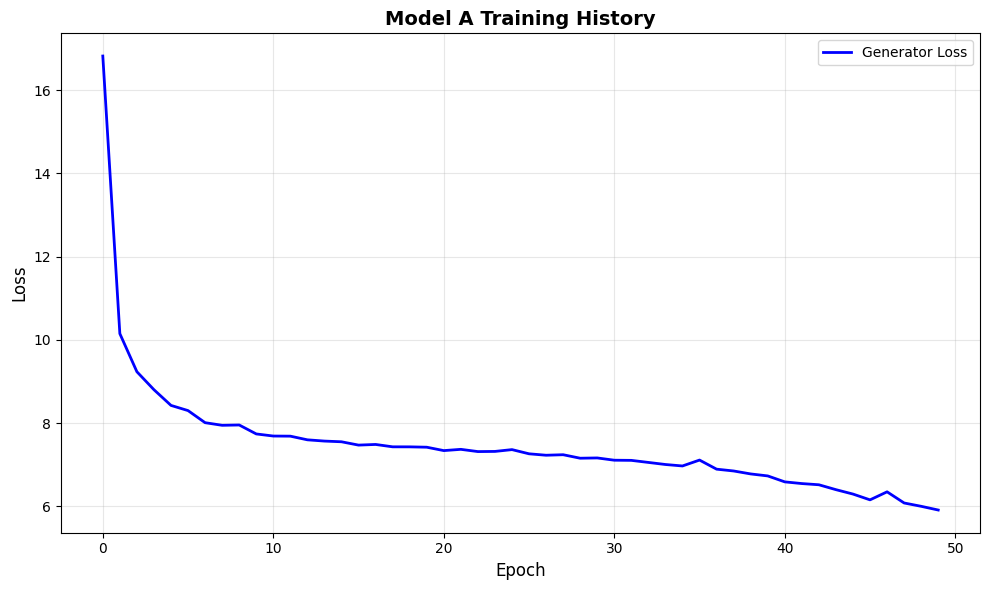

In [10]:
# Save metrics to CSV
results_dir = Path('../results')
results_dir.mkdir(parents=True, exist_ok=True)

metrics_df = pd.DataFrame([{
    'Model_ID': MODEL_ID,
    'Architecture': 'U-Net',
    'GAN': USE_GAN,
    'L1_Loss': USE_L1,
    'Perceptual_Loss': USE_PERCEPTUAL,
    'Lambda_L1': LAMBDA_L1,
    'Lambda_Perceptual': LAMBDA_PERCEPTUAL,
    'PSNR': metrics_avg['PSNR'],
    'SSIM': metrics_avg['SSIM'],
    'CIEDE2000': metrics_avg['CIEDE2000'],
    'LPIPS': metrics_avg['LPIPS'],
    'Best_Loss': best_loss,
    'Epochs': EPOCHS
}])

csv_path = results_dir / f'metrics_{MODEL_ID}.csv'
metrics_df.to_csv(csv_path, index=False)
print(f"✓ Metrics saved to: {csv_path}")

# Save training history plot
plt.figure(figsize=(10, 6))
plt.plot(history['gen_loss'], 'b-', linewidth=2, label='Generator Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title(f'Model {MODEL_ID} Training History', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plot_path = results_dir / f'training_history_{MODEL_ID}.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Training plot saved to: {plot_path}")
plt.show()

✓ Visualization saved to: ..\results\colorization_results_A.png


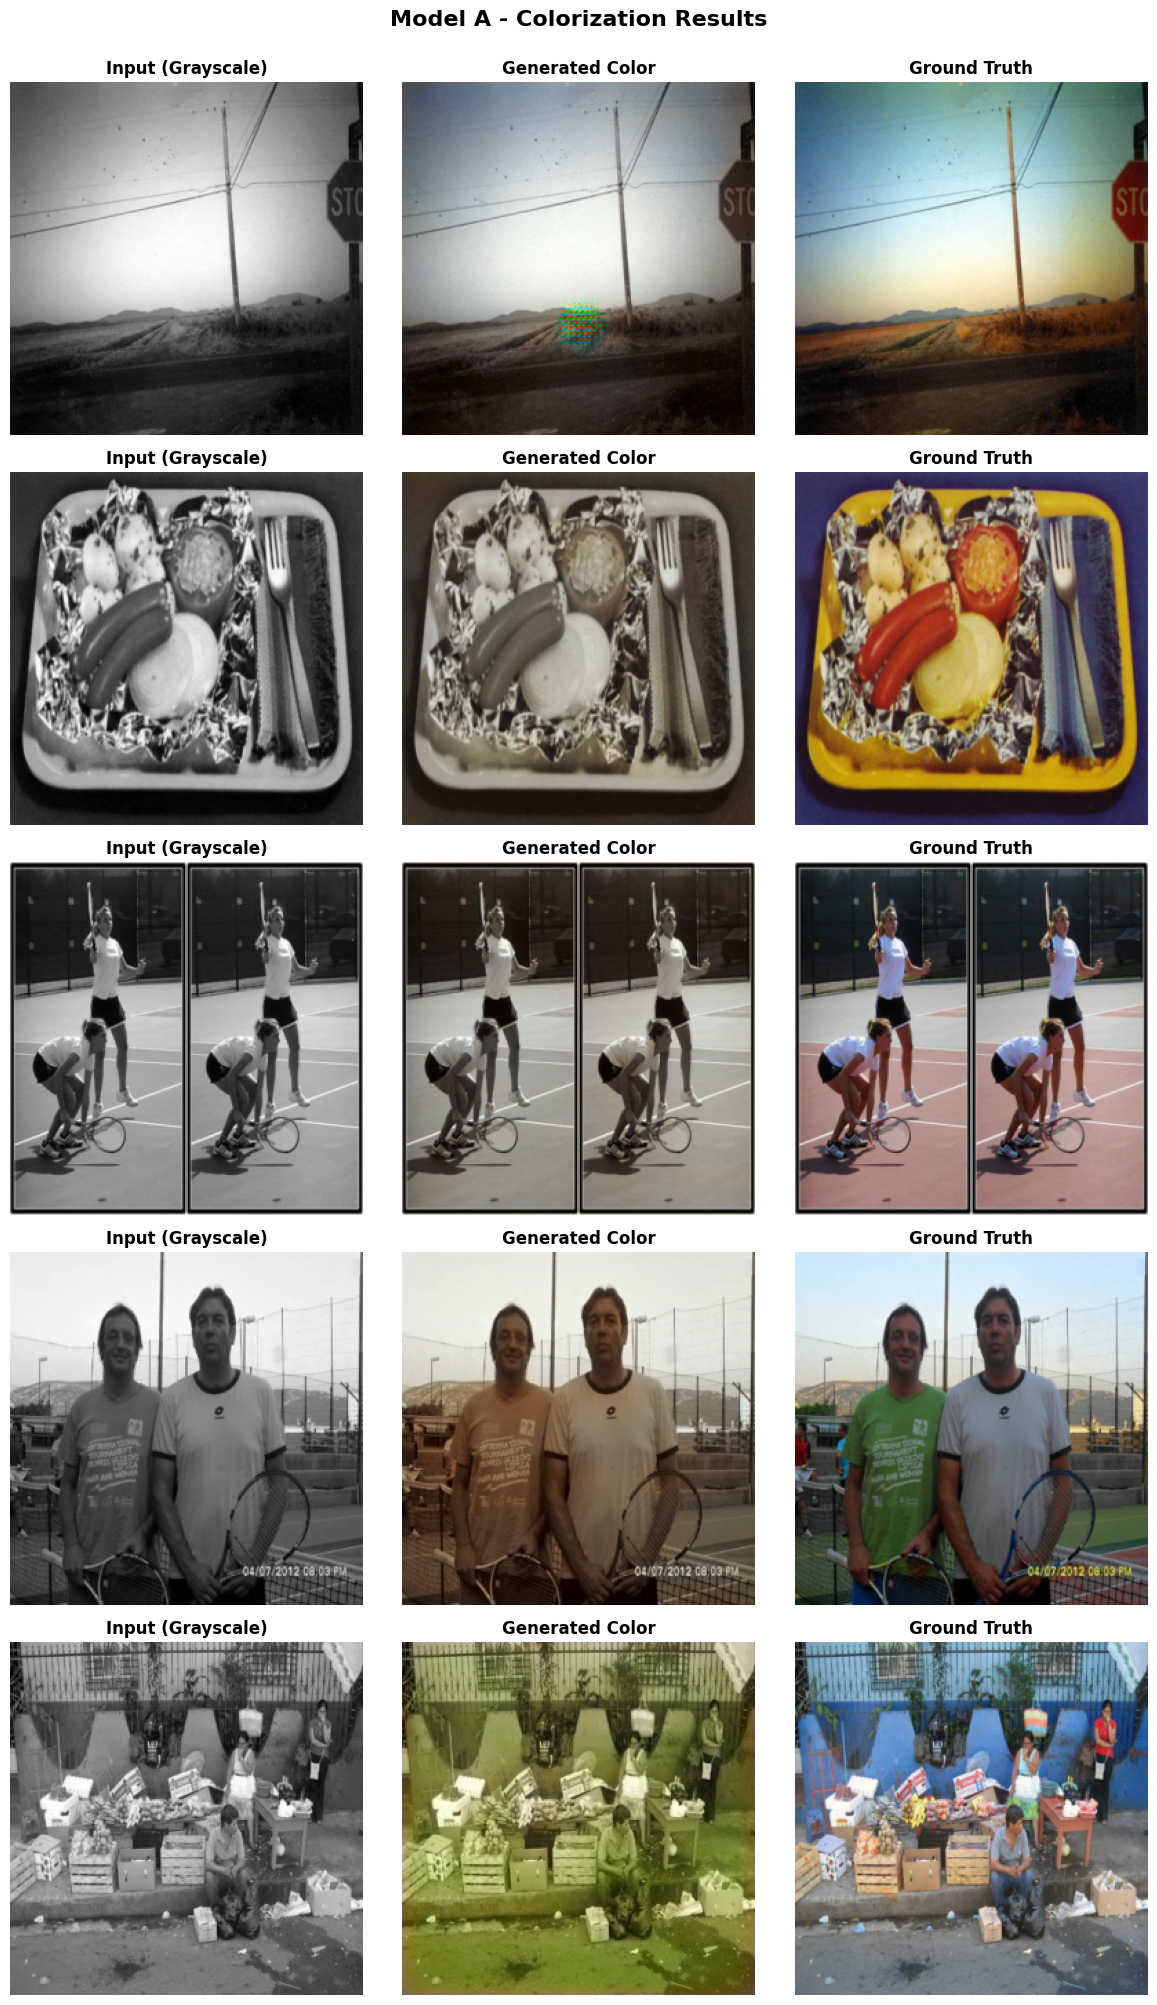


Model A - Training and Evaluation Complete!
Models saved in: ..\models\A
Results saved in: ..\results


In [11]:
# Visualize and save sample results
generator.eval()
num_samples = 5

with torch.no_grad():
    L, ab_real, gray_img = next(iter(test_loader))
    L = L[:num_samples].to(device)
    ab_real = ab_real[:num_samples]
    gray_img = gray_img[:num_samples]
    
    ab_fake = generator(L).cpu()
    L = L.cpu()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    
    for i in range(num_samples):
        # Grayscale input
        axes[i, 0].imshow(gray_img[i].squeeze(), cmap='gray')
        axes[i, 0].set_title('Input (Grayscale)', fontweight='bold')
        axes[i, 0].axis('off')
        
        # Generated colorization
        L_np = ((L[i].squeeze().numpy() + 1.0) * 50.0)
        ab_fake_np = ab_fake[i].permute(1, 2, 0).numpy() * 128.0
        lab_fake = np.zeros((IMG_SIZE, IMG_SIZE, 3))
        lab_fake[:, :, 0] = L_np
        lab_fake[:, :, 1:] = ab_fake_np
        rgb_fake = lab2rgb(lab_fake)
        
        axes[i, 1].imshow(rgb_fake)
        axes[i, 1].set_title('Generated Color', fontweight='bold')
        axes[i, 1].axis('off')
        
        # Ground truth
        ab_real_np = ab_real[i].permute(1, 2, 0).numpy() * 128.0
        lab_real = np.zeros((IMG_SIZE, IMG_SIZE, 3))
        lab_real[:, :, 0] = L_np
        lab_real[:, :, 1:] = ab_real_np
        rgb_real = lab2rgb(lab_real)
        
        axes[i, 2].imshow(rgb_real)
        axes[i, 2].set_title('Ground Truth', fontweight='bold')
        axes[i, 2].axis('off')
    
    plt.suptitle(f'Model {MODEL_ID} - Colorization Results', fontsize=16, fontweight='bold', y=1.0)
    plt.tight_layout()
    
    output_path = results_dir / f'colorization_results_{MODEL_ID}.png'
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"✓ Visualization saved to: {output_path}")
    
    plt.show()

print(f"\n{'='*60}")
print(f"Model {MODEL_ID} - Training and Evaluation Complete!")
print(f"{'='*60}")
print(f"Models saved in: {save_dir}")
print(f"Results saved in: {results_dir}")
print(f"{'='*60}")